# DATASETS

# Primart dataset

### 1. Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

### importing primary data sets


In [ ]:
# Install Kaggle API
!pip install kaggle

# Set up Kaggle API credentials
import os
os.environ['KAGGLE_USERNAME'] = 'your_username'  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_key'           # Replace with your Kaggle API key

# Download the dataset
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

# Extract the dataset
!unzip -o consumer-reviews-of-amazon-products.zip

# Load the dataset
import pandas as pd
df1 = pd.read_csv("1429_1.csv")  # Adjust the file name if needed
df2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")


Dataset URL: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products
License(s): CC-BY-NC-SA-4.0
Archive:  consumer-reviews-of-amazon-products.zip
  inflating: 1429_1.csv              
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv  
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


<ipython-input-2-9ec3d2307b41>:17: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("1429_1.csv")  # Adjust the file name if needed


### Keep Only Relevant Columns in Each Dataset




In [ ]:
df1 = df1[['reviews.rating', 'reviews.text']]
df2 = df2[['reviews.rating', 'reviews.text']]
df3 = df3[['reviews.rating', 'reviews.text']]

### Combine the three datasets into one

In [ ]:
# Combine the three datasets into one
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Drop rows with missing values
combined_df.dropna(inplace=True)

# Verify combined DataFrame structure
print(combined_df.head())  # Check the first few rows to ensure correct data
print(combined_df.columns)  # Ensure 'reviews.rating' and 'reviews.text' are present

   reviews.rating                                       reviews.text
0             5.0  This product so far has not disappointed. My c...
1             5.0  great for beginner or experienced person. Boug...
2             5.0  Inexpensive tablet for him to use and learn on...
3             4.0  I've had my Fire HD 8 two weeks now and I love...
4             5.0  I bought this for my grand daughter when she c...
Index(['reviews.rating', 'reviews.text'], dtype='object')



## exploratory data analysis (EDA)


In [ ]:
# Display general information about the data
print("General Information about the Data:")
print(combined_df.info())

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Columns:")
print(combined_df.describe(include='number'))  # Include only numerical columns

# Check for missing values
print("\nNumber of Missing Values in Each Column:")
print(combined_df.isnull().sum())

General Information about the Data:
<class 'pandas.core.frame.DataFrame'>
Index: 67958 entries, 0 to 67991
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  67958 non-null  float64
 1   reviews.text    67958 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.6+ MB
None

Descriptive Statistics for Numerical Columns:
       reviews.rating
count    67958.000000
mean         4.556064
std          0.825131
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000

Number of Missing Values in Each Column:
reviews.rating    0
reviews.text      0
dtype: int64


### . Map star ratings to sentiment classes
We’ll convert ratings to:

1-2 → Negative

3 → Neutral

4-5 → Positive

In [ ]:
# Define the map_sentiment function
def map_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

# Apply the function to create the 'sentiment' column
combined_df['sentiment'] = combined_df['reviews.rating'].apply(map_sentiment)

# Verify the result
print(combined_df.head())



   reviews.rating                                       reviews.text sentiment
0             5.0  This product so far has not disappointed. My c...  Positive
1             5.0  great for beginner or experienced person. Boug...  Positive
2             5.0  Inexpensive tablet for him to use and learn on...  Positive
3             4.0  I've had my Fire HD 8 two weeks now and I love...  Positive
4             5.0  I bought this for my grand daughter when she c...  Positive


###Balance Ratings (1–5) and Map Sentiment:


In [ ]:
from sklearn.utils import resample
import pandas as pd

# Define the sentiment mapping function based on review ratings
def map_sentiment(rating):
    if rating <= 2:
        return "Negative"    # Ratings 1 or 2 are mapped to Negative
    elif rating == 3:
        return "Neutral"     # Rating 3 is mapped to Neutral
    else:
        return "Positive"    # Ratings 4 or 5 are mapped to Positive

# Apply the sentiment mapping to create a new 'sentiment' column
combined_df['sentiment'] = combined_df['reviews.rating'].apply(map_sentiment)

# Create a list of DataFrames, each containing rows with the same rating (from 1 to 5)
rating_groups = [combined_df[combined_df['reviews.rating'] == i] for i in range(1, 6)]

# Find the largest group size (max number of reviews for any single rating)
max_size = max(len(group) for group in rating_groups)

# Resample each rating group to have the same number of samples as the largest group
# This balances the number of examples per rating
# `replace=True` means we allow duplicates during upsampling
upsampled_groups = [
    resample(group, replace=True, n_samples=max_size, random_state=42)
    for group in rating_groups
]

# Combine the upsampled groups back into a single DataFrame
balanced_df = pd.concat(upsampled_groups)

# Shuffle the final dataset randomly to avoid any ordering bias
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the number of samples for each rating to confirm balance
print("Balanced Rating Counts:")
print(balanced_df['reviews.rating'].value_counts())

# Print the number of samples for each sentiment to see the resulting distribution
print("\nBalanced Sentiment Counts:")
print(balanced_df['sentiment'].value_counts())


Balanced Rating Counts:
reviews.rating
2.0    47149
5.0    47149
4.0    47149
1.0    47149
3.0    47149
Name: count, dtype: int64

Balanced Sentiment Counts:
sentiment
Negative    94298
Positive    94298
Neutral     47149
Name: count, dtype: int64


###Final Clean-Up & Sentiment Mapping

In [ ]:
import pandas as pd

# Ensure the 'sentiment' column has no NaN values or unexpected values
balanced_df['sentiment'] = balanced_df['sentiment'].fillna('Neutral')  # Replace NaNs with 'Neutral'

# Map the 'sentiment' column to numeric values
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
balanced_df['sentiment_numeric'] = balanced_df['sentiment'].map(sentiment_mapping)

# Check column names to verify that 'sentiment_numeric' exists
print(" Columns in balanced_df:")
print(balanced_df.columns)

# Verify unique values in the sentiment column
print("\n Unique values in sentiment column:")
print(balanced_df['sentiment'].unique())

# Show the value counts for each review rating
print("\nValue counts for reviews.rating:")
print(balanced_df['reviews.rating'].value_counts())

# Show how many entries belong to each numeric sentiment class
print("\n Value counts for sentiment_numeric:")
print(balanced_df['sentiment_numeric'].value_counts())


 Columns in balanced_df:
Index(['reviews.rating', 'reviews.text', 'sentiment', 'sentiment_numeric'], dtype='object')

 Unique values in sentiment column:
['Negative' 'Positive' 'Neutral']

Value counts for reviews.rating:
reviews.rating
2.0    47149
5.0    47149
4.0    47149
1.0    47149
3.0    47149
Name: count, dtype: int64

 Value counts for sentiment_numeric:
sentiment_numeric
-1    94298
 1    94298
 0    47149
Name: count, dtype: int64


### Compute Correlation Matrix

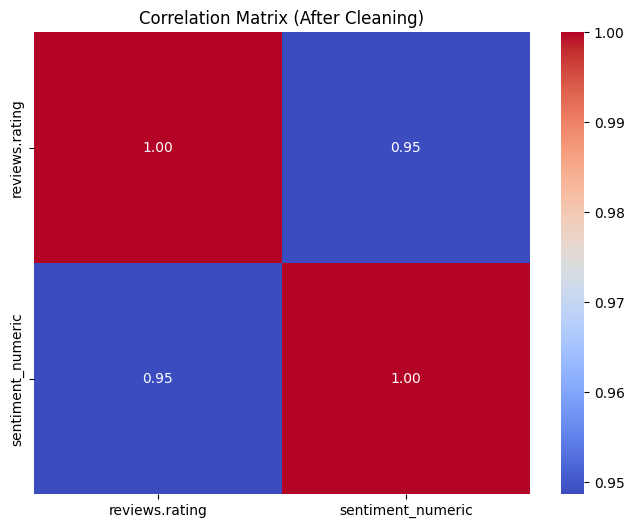

In [ ]:
# Select numerical columns for correlation
numeric_data = balanced_df[['reviews.rating', 'sentiment_numeric']]

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix (After Cleaning)")
plt.show()

### Visualize Sentiment Distribution

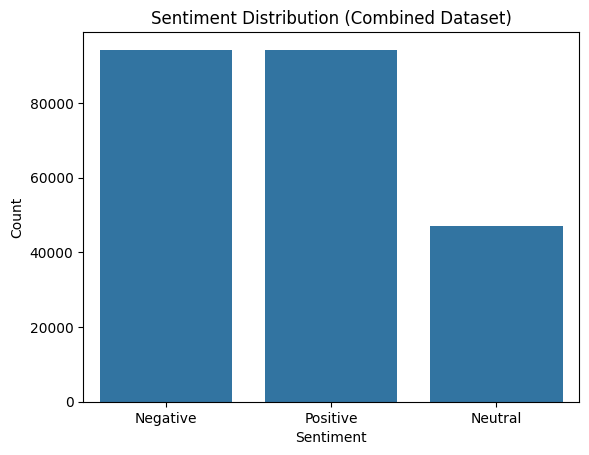

In [ ]:
# Visualize sentiment distribution
sns.countplot(x='sentiment', data= balanced_df)
plt.title('Sentiment Distribution (Combined Dataset)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
pip install wordcloud

### Stemming

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

balanced_df['reviews.text'] = balanced_df['reviews.text'].apply(stem_text)

###Generate Word Clouds for Sentiment Categories

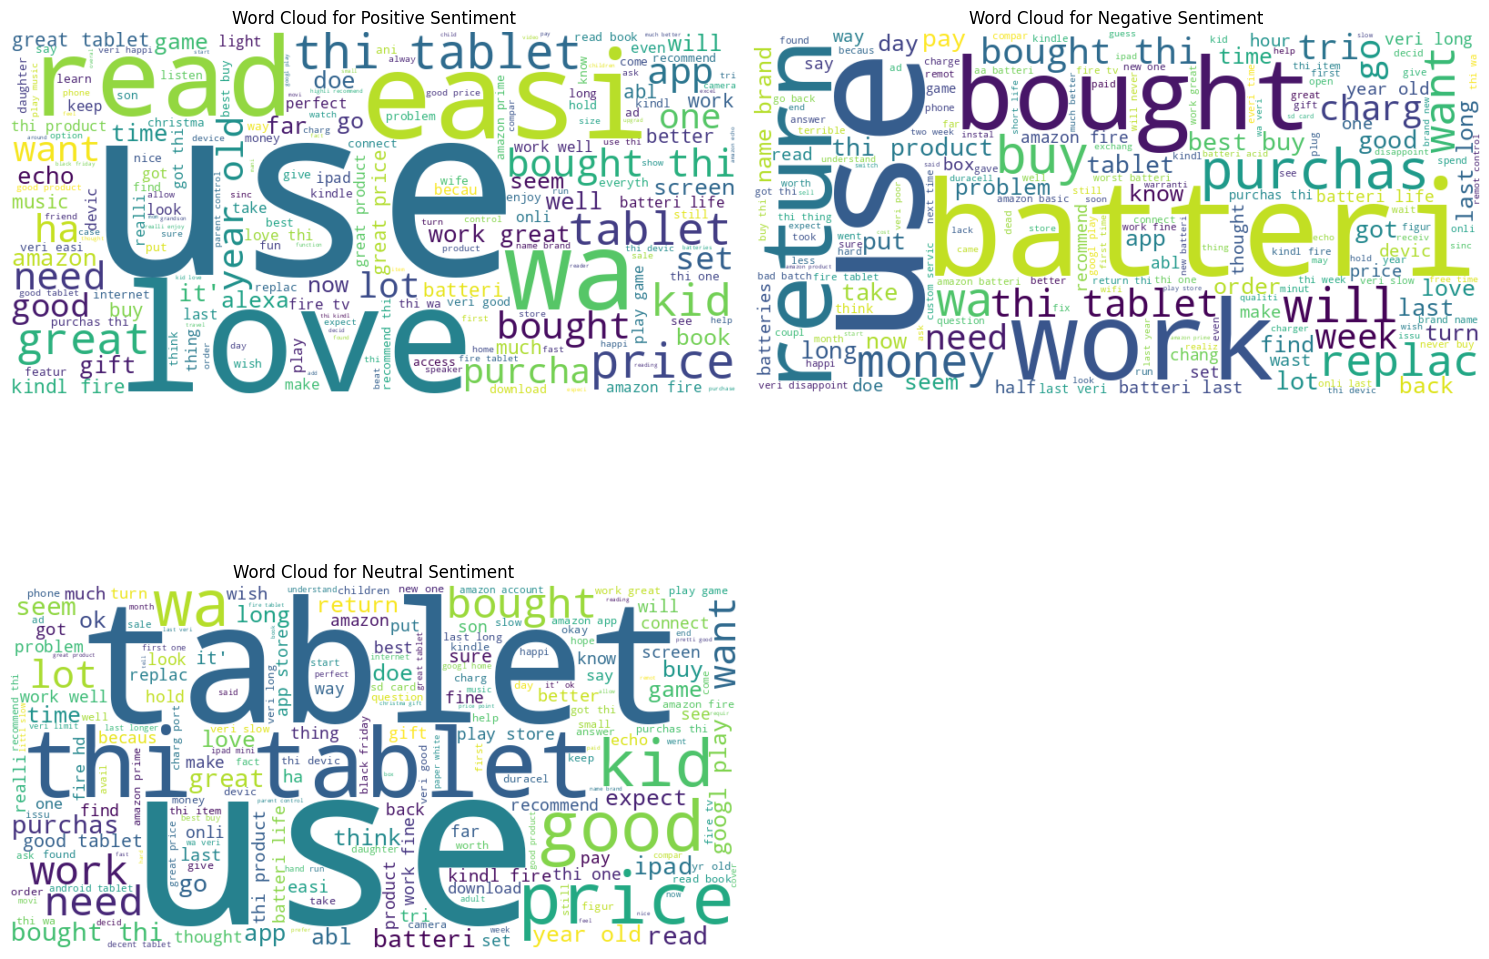

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define custom stopwords to exclude common and non-informative words
custom_stopwords = set(STOPWORDS).union({
    'but', 'and', 'it', 'the', 'a', 'an', 'to', 'is', 'of', 'for', 'on', 'this', 'in', 'that', 'with', 'as', 'at', 'by', 'be', 'are'
})

# Join all review texts for each sentiment category into single large strings
positive_reviews = ' '.join(balanced_df[balanced_df['sentiment'] == 'Positive']['reviews.text'])
negative_reviews = ' '.join(balanced_df[balanced_df['sentiment'] == 'Negative']['reviews.text'])
neutral_reviews  = ' '.join(balanced_df[balanced_df['sentiment'] == 'Neutral']['reviews.text'])

# Generate word clouds for each sentiment with custom stopwords
positive_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white',
                               max_words=200, width=800, height=400).generate(positive_reviews)

negative_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white',
                               max_words=200, width=800, height=400).generate(negative_reviews)

neutral_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white',
                              max_words=200, width=800, height=400).generate(neutral_reviews)

# Plot the word clouds side by side
plt.figure(figsize=(15, 12))

# Positive Word Cloud
plt.subplot(2, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')

# Negative Word Cloud
plt.subplot(2, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')

# Neutral Word Cloud
plt.subplot(2, 2, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')

# Adjust layout and show the result
plt.tight_layout()
plt.show()


# Large Data

### Upload CSV File and Display First 5 Rows:

In [ ]:
import pandas as pd

# Load datasets
reviews_df = pd.read_json(
    "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/All_Beauty.jsonl",
    lines=True
)

sample_size = 25000
all_beauty_df = reviews_df.sample(n=sample_size, random_state=42)  # Fixed sample size
all_beauty_df = all_beauty_df.rename(columns={'text': 'reviews.text'})
all_beauty_df = all_beauty_df.rename(columns={'rating': 'reviews.rating'})
all_beauty_df = all_beauty_df [['reviews.rating', 'reviews.text']]
all_beauty_df.head()

,reviews.rating,reviews.text
558261,5,"Nice formula, smooth application with no pooli..."
533565,5,Great product. It came when expected.
275352,5,My 90 year old mother's favorite fragrance.
658564,1,Just not worth it
48163,5,The Battery life on this product has always be...


### Load Amazon Reviews Dataset from Kaggle

In [ ]:
# Install Kaggle API to access datasets directly from Kaggle
!pip install kaggle

# Import the OS module to set environment variables
import os

# Set up Kaggle API credentials (replace 'your_username' and 'your_key' with your actual Kaggle credentials)
os.environ['KAGGLE_USERNAME'] = 'your_username'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_key'            # Your Kaggle API key

# Download the dataset using the Kaggle API (this dataset contains Amazon product reviews)
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

# Extract the contents of the downloaded ZIP file
!unzip -o consumer-reviews-of-amazon-products.zip

# Import pandas to handle dataframes
import pandas as pd

# Load the CSV files from the dataset into pandas DataFrames
df1 = pd.read_csv("1429_1.csv")  # One of the files in the dataset (might be an older version)
df2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")  # Another version
df3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")  # Latest version


Dataset URL: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products
License(s): CC-BY-NC-SA-4.0
consumer-reviews-of-amazon-products.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  consumer-reviews-of-amazon-products.zip
  inflating: 1429_1.csv              
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv  
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


<ipython-input-15-daad94d5451a>:21: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("1429_1.csv")  # One of the files in the dataset (might be an older version)


### Create a Balanced Sentiment Dataset from Multiple Amazon Review Sources and using larger data

In [ ]:
import pandas as pd

# 1. Load three smaller Kaggle datasets
df1 = pd.read_csv("1429_1.csv", low_memory=False)
df2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv", low_memory=False)
df3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv", low_memory=False)

# 2. Combine and clean Kaggle datasets
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df.dropna(subset=['reviews.rating', 'reviews.text'], inplace=True)

# 3. Sentiment mapping function
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

combined_df['sentiment'] = combined_df['reviews.rating'].apply(map_rating_to_sentiment)

# 4. Filter positive reviews from Kaggle
positive_df = combined_df[combined_df['sentiment'] == 'Positive']
positive_count = len(positive_df)
print(f"✅ Positive reviews in Kaggle datasets: {positive_count}")

# 5. Load the All_Beauty dataset from Hugging Face
all_beauty_df = pd.read_json(
    "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/All_Beauty.jsonl",
    lines=True
)

# 6. Rename and clean All_Beauty dataset
all_beauty_df = all_beauty_df.rename(columns={'rating': 'reviews.rating', 'text': 'reviews.text'})
all_beauty_df.dropna(subset=['reviews.rating', 'reviews.text'], inplace=True)
all_beauty_df['sentiment'] = all_beauty_df['reviews.rating'].apply(map_rating_to_sentiment)

# 7. Count neutral and negative reviews
neutral_count = all_beauty_df[all_beauty_df['sentiment'] == 'Neutral'].shape[0]
negative_count = all_beauty_df[all_beauty_df['sentiment'] == 'Negative'].shape[0]
print(f"🟨 Neutral reviews available: {neutral_count}")
print(f"🟥 Negative reviews available: {negative_count}")

# 8. Balance all sentiment categories
final_count = min(positive_count, neutral_count, negative_count)
print(f"✅ Final balanced count per class: {final_count}")

# 9. Sample each category
positive_final = positive_df.sample(n=final_count, random_state=42)
neutral_final = all_beauty_df[all_beauty_df['sentiment'] == 'Neutral'].sample(n=final_count, random_state=42)
negative_final = all_beauty_df[all_beauty_df['sentiment'] == 'Negative'].sample(n=final_count, random_state=42)

# 10. Combine and export
final_df = pd.concat([positive_final, neutral_final, negative_final], ignore_index=True)
final_df = final_df[['reviews.rating', 'reviews.text', 'sentiment']]
final_df.to_csv('final_reviews_dataset.csv', index=False)

# Summary
print("\n Final sentiment distribution:")
print(final_df['sentiment'].value_counts())
print("✅ Final balanced dataset saved as 'final_reviews_dataset.csv'")


✅ Positive reviews in Kaggle datasets: 62546
🟨 Neutral reviews available: 56307
🟥 Negative reviews available: 145114
✅ Final balanced count per class: 56307

 Final sentiment distribution:
sentiment
Positive    56307
Neutral     56307
Negative    56307
Name: count, dtype: int64
✅ Final balanced dataset saved as 'final_reviews_dataset.csv'


###Clean Sentiment Column and Prepare for Modeling

In [ ]:
import pandas as pd

# Ensure there are no missing sentiment values (just in case)
final_df['sentiment'] = final_df['sentiment'].fillna('Neutral')

# Map sentiment labels to numeric values
sentiment_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}
final_df['sentiment_numeric'] = final_df['sentiment'].map(sentiment_mapping)

# Print columns for structure check
print("✅ Columns in final_df:")
print(final_df.columns.tolist())

# Display unique sentiment labels
print("\n✅ Unique values in 'sentiment' column:")
print(final_df['sentiment'].unique())

# Count rating distribution
print("\n Value counts for 'reviews.rating':")
print(final_df['reviews.rating'].value_counts())

# Count sentiment distribution (numeric)
print("\n Value counts for 'sentiment_numeric':")
print(final_df['sentiment_numeric'].value_counts())


✅ Columns in final_df:
['reviews.rating', 'reviews.text', 'sentiment', 'sentiment_numeric']

✅ Unique values in 'sentiment' column:
['Positive' 'Neutral' 'Negative']

 Value counts for 'reviews.rating':
reviews.rating
3.0    56307
5.0    42466
1.0    39563
2.0    16744
4.0    13841
Name: count, dtype: int64

 Value counts for 'sentiment_numeric':
sentiment_numeric
 1    56307
 0    56307
-1    56307
Name: count, dtype: int64


### Undersample Reviews to Balance Ratings

In [ ]:
import pandas as pd

# Load the dataset that was previously saved
df = pd.read_csv('final_reviews_dataset.csv')  # Ensure this file exists in your working directory

# Show the original rating distribution (1 to 5 stars)
print(" Original distribution of 'reviews.rating':")
print(df['reviews.rating'].value_counts())

# Ensure 'reviews.rating' is numeric (helpful if CSV stored them as strings)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')

# Drop rows where ratings are missing or invalid (just in case)
df = df.dropna(subset=['reviews.rating'])

# Determine the minimum class count to balance the dataset
min_count = df['reviews.rating'].value_counts().min()

# Undersample each rating group to match the minimum count
balanced_df = df.groupby('reviews.rating', group_keys=False).apply(
    lambda x: x.sample(min_count, random_state=42)
)

# Reset index to keep the DataFrame clean
balanced_df = balanced_df.reset_index(drop=True)

# Display the new balanced distribution
print("\n Balanced distribution of 'reviews.rating':")
print(balanced_df['reviews.rating'].value_counts())

# Save the balanced dataset to a new CSV file
balanced_df.to_csv('balanced_reviews.csv', index=False)

# Confirmation message
print("\n The balanced dataset has been saved to 'balanced_reviews.csv'")


 Original distribution of 'reviews.rating':
reviews.rating
3.0    56307
5.0    42466
1.0    39563
2.0    16744
4.0    13841
Name: count, dtype: int64

 Balanced distribution of 'reviews.rating':
reviews.rating
1.0    13841
2.0    13841
3.0    13841
4.0    13841
5.0    13841
Name: count, dtype: int64


<ipython-input-18-385e329b6ae4>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('reviews.rating', group_keys=False).apply(



 The balanced dataset has been saved to 'balanced_reviews.csv'


## saving the new balanced dataset

In [ ]:
from google.colab import files
files.download('balanced_reviews.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### review the Balanced Dataset

In [ ]:
# Load the balanced dataset from the CSV file created earlier
balanced_df = pd.read_csv('balanced_reviews.csv')

# Display the first 5 rows of the dataset to inspect the structure and sample data
print(balanced_df.head())


   reviews.rating                                       reviews.text sentiment
0             1.0  Paint chips right away lasted it two days on m...  Negative
1             1.0  It did not look like picture at all. Hair shor...  Negative
2             1.0                    Incorrect product  description.  Negative
3             1.0  Used this product about 5 times. It has stoppe...  Negative
4             1.0                                    Didn't owe well  Negative


# Classification Model

## Model Definition

In [ ]:
# ✅ Sentiment Classification Model using RoBERTa (Model Definition)

from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, model_name='roberta-base', num_labels=3):
        super(SentimentClassifier, self).__init__()
        # Load pre-trained RoBERTa model with a classification head
        self.roberta = RobertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels  # Set the number of sentiment classes
        )

    def forward(self, input_ids, attention_mask, labels=None):
        # Forward pass through the model
        return self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )


### clean and review text data

In [ ]:
# Function to clean review text data
def clean_text(text):
    if isinstance(text, str):  # Ensure it's a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply text cleaning to review texts
combined_df['reviews.text'] = combined_df['reviews.text'].apply(clean_text)

# Drop unnecessary columns (adjust column names as per your dataset)
columns_to_drop = ['date', 'subject', 'reviews.title', 'reviews.username']
combined_df = combined_df.drop(columns=[col for col in columns_to_drop if col in combined_df.columns])

# Display a sample of the cleaned data
print("Processed Data Sample:")
print(combined_df.head())

Processed Data Sample:
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
2  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
3  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
4  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   

                                                key

## Model for Review Classification

# 1-MODEL A

In [ ]:
# ===============================
# Import Libraries
# ===============================
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive


Configuration

In [ ]:
# ===============================
# Configuration
# ===============================
CONFIG = {
    "model_name": "distilroberta-base",
    "max_length": 128,
    "test_size": 0.2,
    "random_state": 42,
    "n_folds": 3,
    "class_names": ['Negative', 'Neutral', 'Positive']
}


Data Preparation

In [ ]:
def load_and_prepare_data():
    print("📂 Loading and preparing dataset...")

    file_names = [
        "1429_1.csv",
        "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",
        "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
    ]

    dfs = []
    for file_name in tqdm(file_names, desc="Loading files"):
        try:
            df_tmp = pd.read_csv(file_name, low_memory=False)
            dfs.append(df_tmp)
        except Exception as e:
            print(f"⚠️ Error loading {file_name}: {str(e)}")

    if not dfs:
        raise ValueError("No data files could be loaded")

    combined_df = pd.concat(dfs, ignore_index=True)

    def find_column(columns, options):
        return next((col for col in options if col in columns), None)

    rating_col = find_column(combined_df.columns, ['reviews.rating', 'rating', 'Rating'])
    text_col = find_column(combined_df.columns, ['reviews.text', 'text', 'Review'])

    if not rating_col or not text_col:
        raise ValueError("Required columns not found.")

    def map_sentiment(rating):
        try:
            rating = float(rating)
            return 0 if rating <= 2 else (1 if rating == 3 else 2)
        except:
            return 1

    combined_df['sentiment'] = combined_df[rating_col].apply(map_sentiment)
    combined_df = combined_df.dropna(subset=[text_col, 'sentiment'])
    combined_df = combined_df[combined_df[text_col].apply(lambda x: isinstance(x, str))]
    combined_df[text_col] = combined_df[text_col].str.replace(r'\s+', ' ', regex=True).str.strip()
    combined_df = combined_df[combined_df[text_col].str.len() > 10]
    combined_df = combined_df.drop_duplicates(subset=[text_col])

    return combined_df, text_col


Custom Dataset

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


Metrics Function

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    class_report = classification_report(
        labels, preds,
        target_names=CONFIG['class_names'],
        output_dict=True
    )

    return {
        'accuracy': acc,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'class_report': class_report
    }


Visualization

In [ ]:
def plot_training_metrics(trainer, save_path="training_metrics.png"):
    logs = trainer.state.log_history
    train_loss = [log['loss'] for log in logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

    def smooth_curve(points, factor=0.8):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(smooth_curve(train_loss), label='Train Loss', color='blue')
    plt.plot(smooth_curve(eval_loss), label='Validation Loss', color='red')
    plt.title('Loss Progression')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(smooth_curve(eval_accuracy), label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, save_path="confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CONFIG['class_names'],
        yticklabels=CONFIG['class_names']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


Training + Saving


In [ ]:
def train_model():
    combined_df, text_col = load_and_prepare_data()

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        combined_df[text_col].tolist(),
        combined_df['sentiment'].tolist(),
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_state'],
        stratify=combined_df['sentiment']
    )

    tokenizer = RobertaTokenizer.from_pretrained(CONFIG['model_name'])
    model = RobertaForSequenceClassification.from_pretrained(
        CONFIG['model_name'],
        num_labels=3,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )

    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    train_dataset = ReviewDataset(train_texts, train_labels, tokenizer, CONFIG['max_length'])
    test_dataset = ReviewDataset(test_texts, test_labels, tokenizer, CONFIG['max_length'])

    training_args = TrainingArguments(
        output_dir="./results_optimized",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=8,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir="./logs_optimized",
        logging_steps=50,
        save_total_limit=1,
        load_best_model_at_end=True,
        lr_scheduler_type="cosine",
        learning_rate=2e-5,
        fp16=True,
        run_name="optimized-sentiment-training",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print("🚀 Starting optimized training...")
    trainer.train()

    save_path = "saved_optimized_model"
    os.makedirs(save_path, exist_ok=True)
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"💾 Model saved to: {save_path}")

    try:
        drive.mount('/content/drive')
        drive_save_path = "/content/drive/MyDrive/sentiment_optimized_model"
        os.makedirs(drive_save_path, exist_ok=True)
        model.save_pretrained(drive_save_path)
        tokenizer.save_pretrained(drive_save_path)
        print(f" Model also saved to Google Drive: {drive_save_path}")
    except Exception as e:
        print(f" Could not save to Google Drive: {str(e)}")

    print(" Evaluating on test set...")
    model.eval()
    y_true, y_pred = [], []

    for data in tqdm(test_dataset, desc="Evaluating"):
        inputs = {k: v.unsqueeze(0).to(model.device) for k, v in data.items() if k != 'labels'}
        label = data['labels'].item()
        with torch.no_grad():
            outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
        y_pred.append(prediction)
        y_true.append(label)

    print(f'\n Test Accuracy: {accuracy_score(y_true, y_pred):.4f}')
    print("\n Classification Report:")
    report = classification_report(y_true, y_pred, target_names=CONFIG['class_names'])
    print(report)

    with open("classification_report_optimized.txt", "w") as f:
        f.write(report)

    plot_training_metrics(trainer, "training_metrics_optimized.png")
    plot_confusion_matrix(y_true, y_pred, "confusion_matrix_optimized.png")

    return model, tokenizer, trainer


Run

📂 Loading and preparing dataset...


Loading files: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


🚀 Starting optimized training...


Epoch,Training Loss,Validation Loss,Accuracy,Weighted Precision,Weighted Recall,Weighted F1,Macro Precision,Macro Recall,Macro F1,Class Report
1,0.200800,0.176147,0.941663,0.924121,0.941663,0.929602,0.686614,0.598885,0.619588,"{'Negative': {'precision': 0.7134670487106017, 'recall': 0.6821917808219178, 'f1-score': 0.6974789915966386, 'support': 365.0}, 'Neutral': {'precision': 0.3875968992248062, 'recall': 0.12254901960784313, 'f1-score': 0.186219739292365, 'support': 408.0}, 'Positive': {'precision': 0.9587768969422423, 'recall': 0.9919156414762742, 'f1-score': 0.9750647854880506, 'support': 8535.0}, 'accuracy': 0.9416630855178342, 'macro avg': {'precision': 0.6866136149592167, 'recall': 0.5988854806353451, 'f1-score': 0.6195878387923514, 'support': 9308.0}, 'weighted avg': {'precision': 0.9241207373297303, 'recall': 0.9416630855178342, 'f1-score': 0.9296020014723433, 'support': 9308.0}}"
2,0.156200,0.196610,0.941018,0.930060,0.941018,0.933547,0.683631,0.645496,0.649909,"{'Negative': {'precision': 0.6610576923076923, 'recall': 0.7534246575342466, 'f1-score': 0.704225352112676, 'support': 365.0}, 'Neutral': {'precision': 0.42408376963350786, 'recall': 0.19852941176470587, 'f1-score': 0.2704507512520868, 'support': 408.0}, 'Positive': {'precision': 0.9657510630961958, 'recall': 0.9845342706502637, 'f1-score': 0.975052216291483, 'support': 8535.0}, 'accuracy': 0.941018478727976, 'macro avg': {'precision': 0.683630841679132, 'recall': 0.6454961133164053, 'f1-score': 0.6499094398854153, 'support': 9308.0}, 'weighted avg': {'precision': 0.9300599010774399, 'recall': 0.941018478727976, 'f1-score': 0.9335471450450993, 'support': 9308.0}}"
3,0.116000,0.210024,0.940481,0.931149,0.940481,0.934349,0.679563,0.653954,0.655875,"{'Negative': {'precision': 0.6555819477434679, 'recall': 0.7561643835616438, 'f1-score': 0.7022900763358778, 'support': 365.0}, 'Neutral': {'precision': 0.4155251141552511, 'recall': 0.22303921568627452, 'f1-score': 0.2902711323763955, 'support': 408.0}, 'Positive': {'precision': 0.9675819104753115, 'recall': 0.9826596367896895, 'f1-score': 0.9750624891007382, 'support': 8535.0}, 'accuracy': 0.9404813064030941, 'macro avg': {'precision': 0.6795629907913435, 'recall': 0.6539544120125359, 'f1-score': 0.6558745659376705, 'support': 9308.0}, 'weighted avg': {'precision': 0.9311488250331427, 'recall': 0.9404813064030941, 'f1-score': 0.9343494675920677, 'support': 9308.0}}"
4,0.104300,0.241429,0.942200,0.931057,0.942200,0.935124,0.700926,0.635058,0.657418,"{'Negative': {'precision': 0.7030812324929971, 'recall': 0.6876712328767123, 'f1-score': 0.6952908587257618, 'support': 365.0}, 'Neutral': {'precision': 0.4351851851851852, 'recall': 0.23039215686274508, 'f1-score': 0.30128205128205127, 'support': 408.0}, 'Positive': {'precision': 0.9645105895821409, 'recall': 0.987111892208553, 'f1-score': 0.9756803705848291, 'support': 8535.0}, 'accuracy': 0.942200257842716, 'macro avg': {'precision': 0.7009256690867743, 'recall': 0.6350584273160035, 'f1-score': 0.6574177601975474, 'support': 9308.0}, 'weighted avg': {'precision': 0.9310569496668534, 'recall': 0.942200257842716, 'f1-score': 0.9351242160828853, 'support': 9308.0}}"


💾 Model saved to: saved_optimized_model
Mounted at /content/drive
💾 Model also saved to Google Drive: /content/drive/MyDrive/sentiment_optimized_model
🧪 Evaluating on test set...


Evaluating: 100%|██████████| 9308/9308 [01:09<00:00, 133.23it/s]



🎯 Test Accuracy: 0.9417

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.68      0.70       365
     Neutral       0.39      0.12      0.19       408
    Positive       0.96      0.99      0.98      8535

    accuracy                           0.94      9308
   macro avg       0.69      0.60      0.62      9308
weighted avg       0.92      0.94      0.93      9308



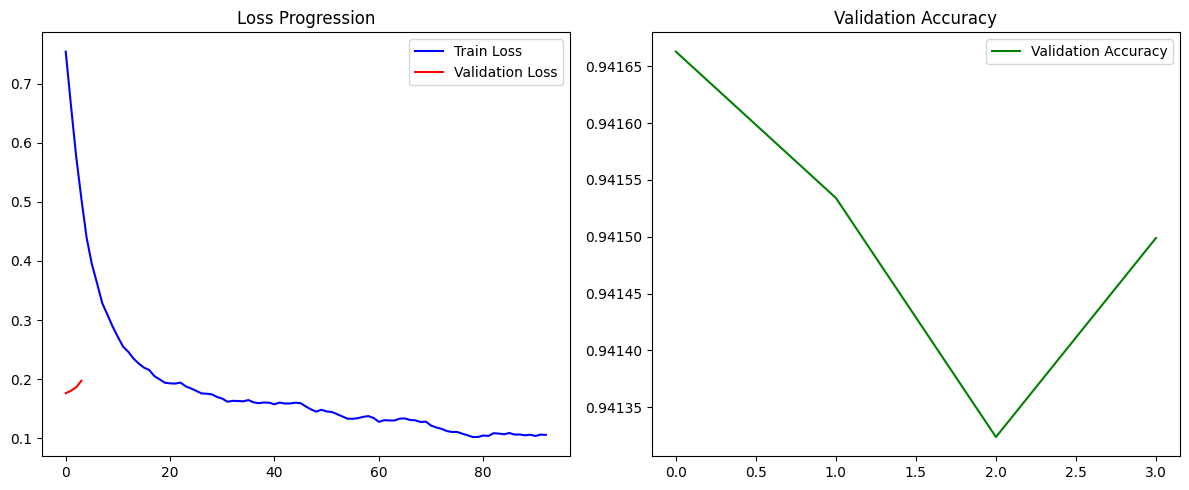

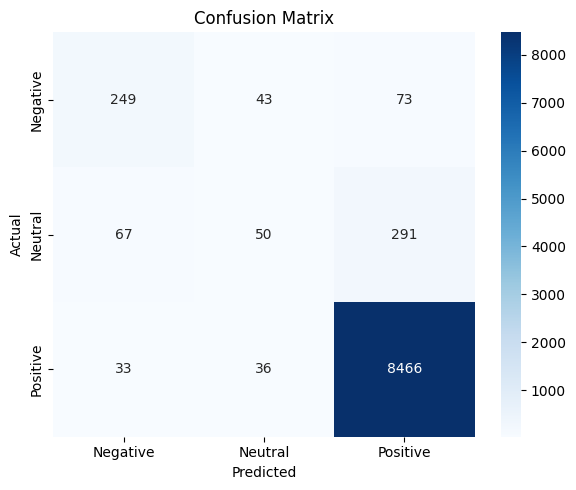

In [ ]:
model, tokenizer, trainer = train_model()


____________________________________________

_______________________________________________________________________________________

# MODEL B using Larg Data

Install & Import Libraries

In [ ]:
# -*- coding: utf-8 -*-
"""
Professional Sentiment Analysis Pipeline with Transformers
"""

# Install required packages (if running in Colab)
!pip install transformers datasets evaluate -q

# Import libraries
import pandas as pd
import torch
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform

Configuration

In [ ]:
# Configuration
MODEL_NAME = "distilroberta-base"
NUM_LABELS = 3
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
OUTPUT_DIR = "./sentiment_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)


Data Loading & Preprocessing

In [ ]:
print("\n DATA LOADING & PREPROCESSING")

try:
    df = pd.read_csv("balanced_reviews.csv")
    print(f" Data loaded successfully ({len(df)} records)")

    # Detect column names
    rating_col = next((c for c in ['reviews.rating', 'rating', 'Rating'] if c in df.columns), None)
    text_col = next((c for c in ['reviews.text', 'text', 'Review'] if c in df.columns), None)

    if not rating_col or not text_col:
        raise ValueError("Missing required columns (rating/text)")

    # Map ratings to sentiment
    def map_sentiment(r):
        try:
            r = float(r)
            return 0 if r <= 2 else 1 if r == 3 else 2
        except:
            return 1  # Neutral fallback

    df['sentiment'] = df[rating_col].apply(map_sentiment)
    df = df.dropna(subset=[text_col, 'sentiment'])
    df = df[df[text_col].apply(lambda x: isinstance(x, str) and len(x.strip()) > 10)]
    df[text_col] = df[text_col].str.replace(r'\s+', ' ', regex=True).str.strip()

    print("\n Sentiment Distribution:")
    print(df['sentiment'].value_counts())

except Exception as e:
    print(f" Error: {str(e)}")



📊 DATA LOADING & PREPROCESSING
❌ Error: name 'pd' is not defined


Dataset Preparation


In [ ]:
print("\n DATASET PREPARATION")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[text_col].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

print(f" Train size: {len(train_dataset)}")
print(f" Test size: {len(test_dataset)}")



🧠 DATASET PREPARATION


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

NameError: name 'df' is not defined

Model Configuration



In [ ]:
print("\n MODEL CONFIGURATION")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
)

history = {'train_loss': [], 'eval_loss': [], 'eval_accuracy': [], 'epoch': []}

class HistoryCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs and 'epoch' in logs:
                history['train_loss'].append(logs['loss'])
                history['epoch'].append(logs['epoch'])
            if 'eval_loss' in logs:
                history['eval_loss'].append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                history['eval_accuracy'].append(logs['eval_accuracy'])

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    logging_strategy="steps",
    save_total_limit=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[HistoryCallback()]
)


Train the Model

In [ ]:
print("\n MODEL TRAINING")

train_result = trainer.train()
trainer.save_model()
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)


Evaluation & Plots

In [ ]:
print("\n MODEL EVALUATION")

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = test_labels

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

print("\n Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

eval_metrics = predictions.metrics
trainer.log_metrics("eval", eval_metrics)
trainer.save_metrics("eval", eval_metrics)

# Plots
if len(history['eval_accuracy']) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(history['eval_accuracy'], 'g-', marker='o', label='Validation Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], 'b-', marker='o', label='Train Loss')
    plt.plot(history['eval_loss'], 'r-', marker='o', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print(" No metrics to plot.")


Save Model & Tokenizer in Colab


In [ ]:
print("\n Saving model and tokenizer locally in Colab...")

# Save model and tokenizer locally
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# Show saved files
print(" Files saved to:", OUTPUT_DIR)
print(" Content of directory:")
!ls -l $OUTPUT_DIR



💾 Saving model and tokenizer locally in Colab...
✅ Files saved to: ./sentiment_model
📁 Content of directory:
total 325544
-rw-r--r-- 1 root root       506 Apr 13 19:33 all_results.json
drwxr-xr-x 2 root root      4096 Apr 13 19:32 checkpoint-10182
drwxr-xr-x 2 root root      4096 Apr 13 19:27 checkpoint-6788
-rw-r--r-- 1 root root       853 Apr 13 19:33 config.json
-rw-r--r-- 1 root root       302 Apr 13 19:33 eval_results.json
-rw-r--r-- 1 root root    456318 Apr 13 19:33 merges.txt
-rw-r--r-- 1 root root 328495356 Apr 13 19:33 model.safetensors
-rw-r--r-- 1 root root       280 Apr 13 19:33 special_tokens_map.json
-rw-r--r-- 1 root root      1246 Apr 13 19:33 tokenizer_config.json
-rw-r--r-- 1 root root   3558908 Apr 13 19:33 tokenizer.json
-rw-r--r-- 1 root root      5304 Apr 13 19:32 training_args.bin
-rw-r--r-- 1 root root       206 Apr 13 19:32 train_results.json
-rw-r--r-- 1 root root    798293 Apr 13 19:33 vocab.json


In [ ]:
from google.colab import drive
import shutil

# 1. Mount Google Drive to access it
drive.mount('/content/drive')

# 2. Define the local directory to save the model and tokenizer
OUTPUT_DIR = "/content/sentiment_model"

# 3. Save the model and tokenizer to the local directory
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# 4. Create a ZIP archive of the saved model folder
ZIP_PATH = "/content/sentiment_model.zip"
shutil.make_archive("/content/sentiment_model", 'zip', OUTPUT_DIR)

# 5. Move the ZIP archive to Google Drive
DEST_PATH = "/content/drive/MyDrive/sentiment_model.zip"
shutil.move(ZIP_PATH, DEST_PATH)

print(" Model and tokenizer saved as ZIP in Google Drive!")
print(" File path in Drive:", DEST_PATH)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

D

## Clustering Model

### importing libraries for clustering

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import logging
import os

###Data Loading

In [ ]:
df1 = pd.read_csv("1429_1.csv")
df2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df = pd.concat([df1, df2, df3], ignore_index=True)

# keeping only relevant columns
df = df.dropna(subset=['name', 'categories', 'reviews.text'])

FileNotFoundError: [Errno 2] No such file or directory: '1429_1.csv'

### Cleaning the data

In [ ]:
nlp = spacy.load('en_core_web_sm')
def advanced_clean(text):
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', str(text).lower())
    doc = nlp(text)

    # Phwrase detection patterns
    phrase_patterns = [
        [{'POS': 'NOUN'}, {'POS': 'NOUN'}],
        [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
        [{'POS': 'VERB'}, {'POS': 'NOUN'}]
    ]
    matcher = spacy.matcher.Matcher(nlp.vocab)
    for pattern in phrase_patterns:
        matcher.add("PHRASE", [pattern])

    matches = matcher(doc)

    # Fix: Ensure end index is within bounds
    phrases = ["_".join([doc[start].lemma_, doc[end -1].lemma_]) # Changed: use end-1
              for _, start, end in matches if end <= len(doc)] #Changed: Check if the end is within bounds

    # Token processing
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and len(token.lemma_) > 2:
            if token.lemma_ in ['battery', 'batteries']:
                tokens.append('battery')
            elif token.lemma_ in ['charge', 'charger', 'charging']:
                tokens.append('charger')
            else:
                tokens.append(token.lemma_)

    return ' '.join(tokens + phrases)

# Combine the three columns with space separators
df['combined_text'] = (
    df['name'].astype(str) + " " +
    df['categories'].astype(str) + " " +
    df['reviews.text'].astype(str)
)

# Apply advanced_clean to the combined text
print("\nCleaning combined text data...")
tqdm.pandas()  # Enable progress bar
df['final_cleaned'] = df['combined_text'].progress_apply(advanced_clean)

df.drop('combined_text', axis=1, inplace=True)

# Show sample results
print("\nSample cleaned text:")
print(df[['name', 'categories', 'reviews.text', 'final_cleaned']].head(3))

### Embedding Generation

In [ ]:
#Optimized Embedding Generation+ dimensionality reduction

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['final_cleaned'].tolist(),
                         show_progress_bar=True,
                         batch_size=128,
                         convert_to_numpy=True)

# Reduce dimensionality with UMAP
reducer = UMAP(n_components=64, random_state=42, metric='cosine')
reduced_embeds = reducer.fit_transform(embeddings)
print(f"Reduced embedding shape: {reduced_embeds.shape}")

###Kmeans

In [ ]:
#Cluster Determination with Silhouette Score Evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

def find_optimal_clusters(data, min_k=4, max_k=6):
    scores = []
    for k in tqdm(range(min_k, max_k+1)):
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = kmeans.fit_predict(data)

        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        scores.append({
            'k': k,
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'model': kmeans
        })

        print(f"For n_clusters = {k}, silhouette score is {sil_score:.3f}")

    return pd.DataFrame(scores)

cluster_df = find_optimal_clusters(reduced_embeds)
best_row = cluster_df.iloc[cluster_df['silhouette'].idxmax()]
best_k = best_row['k']
best_model = best_row['model']

print(f"Optimal clusters: {best_k} with silhouette {best_row['silhouette']:.3f}")

###Refinement

In [ ]:
# Enhanced Clustering with Refinement
from sklearn.neighbors import NearestNeighbors

def refine_clusters(embeddings, labels):
    # Remove small clusters
    counts = pd.Series(labels).value_counts()
    small_clusters = counts[counts < 0.01*len(labels)].index
    labels[np.isin(labels, small_clusters)] = -1

    # Reassign outliers
    nn = NearestNeighbors(n_neighbors=50).fit(embeddings)
    distances, indices = nn.kneighbors(embeddings)

    for i in np.where(labels == -1)[0]:
        neighbor_labels = labels[indices[i]]
        valid_labels = neighbor_labels[neighbor_labels != -1]
        if len(valid_labels) > 0:
            labels[i] = np.bincount(valid_labels).argmax()

    return labels

df['cluster'] = refine_clusters(reduced_embeds, best_model.labels_)
print("Cluster counts after refinement:")
print(df['cluster'].value_counts())

###Visualization

In [ ]:
#Advanced Visualization and Cluster Analysis
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from collections import Counter
import matplotlib.pyplot as plt

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
vis_embeds = tsne.fit_transform(reduced_embeds)

plt.figure(figsize=(12,8))
scatter = plt.scatter(vis_embeds[:,0], vis_embeds[:,1],
                     c=df['cluster'], cmap='Spectral', alpha=0.6)
plt.colorbar(scatter)
plt.title("t-SNE Cluster Visualization")
plt.show()

def analyze_clusters_with_ignored_words(df, ignored_words=None):
    """Analyze clusters with customizable word filtering"""
    if ignored_words is None:
        # Default ignored words if none provided
        ignored_words = ['amazon']

    # Convert ignored words to lowercase for case-insensitive matching
    ignored_words = [word.lower() for word in ignored_words]

    # 1. Basic cluster analysis (products and categories)
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]

        # Top meaningful words analysis with ignored words filtering
        print(f"Top meaningful words in Cluster \n{cluster_id} ")
        # Get all text for this cluster
        cluster_texts = ' '.join(df[df['cluster'] == cluster_id]['final_cleaned'])

        # Tokenize and filter out ignored words
        words = [word for word in cluster_texts.split()
                if word.lower() not in ignored_words]

        # Get top 20 meaningful words (after filtering)
        top_words = Counter(words).most_common(10)

        print([word for word, count in top_words])

# Custom list of words to ignore (common but less meaningful words)
custom_ignored_words = [
    'great', 'product', 'bought', 'easy', 'love', 'loves', 'good', 'works', 'amazon',
    'box', 'use', 'like', 'one', 'echo', 'get', 'got', 'year', 'really', 'best', 'buy',
    'also', 'fire', 'would', 'dont', 'well', 'much', 'old', 'time', 'set', 'recommend',
    'happy', 'quality', 'books', 'screen', 'kids', 'long', 'price', 'battery',
    'things', 'weather', 'day', 'first', 'new', 'made', 'make', 'makes', 'special', 'offers' , 'may',
    'even', 'still', 'every', 'many', 'need', 'needs', 'perfect', 'excellent', 'nice', '8','aa',
    'awesome', 'fine', 'ok', 'okay', 'better', 'bad', 'worst', 'terrible', 'horrible', '&','-','7','16'
]

# Run analysis with custom ignored words
analyze_clusters_with_ignored_words(df, ignored_words=custom_ignored_words)

### Saving the model

In [ ]:
# Save the trained model for deployment
from sentence_transformers import SentenceTransformer
model_save_path = 'cluster_model'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

# Load the saved model
#loaded_model = SentenceTransformer("cluster_model")

In [ ]:
import joblib

# Save UMAP reducer
joblib.dump(reducer, "umap_reducer.pkl")
# Save KMeans clustering model
joblib.dump(best_model, "kmeans_model.pkl")

print("UMAP reducer and KMeans model saved")

# Load the saved components
#loaded_reducer = joblib.load("umap_reducer.pkl")
#loaded_kmeans = joblib.load("kmeans_model.pkl")

## Summarization Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install and import
!pip install --upgrade openai
import pandas as pd
from collections import defaultdict
from openai import OpenAI

# Load the data
df = pd.read_csv('/content/drive/MyDrive/cleaned_reviews.csv')  # Adjust path if needed

# Step 1: Convert to structured review data
def convert_df_to_json(df):
    grouped_data = defaultdict(lambda: {"reviews": [], "category": ""})

    for _, row in df.iterrows():
        product = row.get('name')
        category = str(row.get('categories')).split(',')[0] if pd.notnull(row.get('categories')) else "Misc"
        review_text = row.get('reviews.text')
        rating = row.get('reviews.rating')

        if pd.notnull(review_text) and pd.notnull(rating):
            grouped_data[product]["reviews"].append({
                "text": str(review_text),
                "rating": float(rating)
            })
            grouped_data[product]["category"] = category

    structured_reviews = []
    for product, details in grouped_data.items():
        if len(details["reviews"]) >= 2:
            ratings = [r["rating"] for r in details["reviews"]]
            texts = [r["text"] for r in details["reviews"]]

            structured_reviews.append({
                "product_name": product,
                "category": details["category"],
                "avg_rating": sum(ratings) / len(ratings),
                "top_pros": [t for t in texts if "good" in t.lower() or "great" in t.lower()][:2],
                "top_complaints": [t for t in texts if "bad" in t.lower() or "disappoint" in t.lower()][:2]
            })
    return structured_reviews

# Step 2: Group insights by category
def group_by_category(insights):
    category_map = defaultdict(list)
    for item in insights:
        category_map[item['category']].append(item)
    return category_map

# Step 3: Build insight string for GPT
def build_insight_string(products):
    sorted_products = sorted(products, key=lambda x: x["avg_rating"], reverse=True)
    top_3 = sorted_products[:3]
    worst = sorted_products[-1]

    insights_str = ""
    for idx, p in enumerate(top_3, 1):
        insights_str += f"""{idx}. {p['product_name']} - Rating: {p['avg_rating']:.2f}
Key Pros: {", ".join(p['top_pros']) or "N/A"}
Top Complaints: {", ".join(p['top_complaints']) or "N/A"}\n\n"""

    insights_str += f"Worst Product:\n{worst['product_name']} - Rating: {worst['avg_rating']:.2f}\n"
    insights_str += f"Complaints: {', '.join(worst['top_complaints']) or 'N/A'}"

    return insights_str

# Step 4: GPT-4 article generation
client = OpenAI(api_key="API_KEY")

def generate_article(category, insights):
    prompt = f"""
You are a professional tech writer.

Write a clear, structured summary about the product category: "{category}".

The summary should include:
1. Top 3 products in this category and their key differences.
2. Top complaints for each of those top 3 products.
3. The worst product and why users should avoid it.

Make it professional, insightful, and easy to read — no bullet points or lists.

Here are the insights to use:
{insights}

Now write the article.
"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=900
    )
    return response.choices[0].message.content

# Step 5: Run for each category
structured = convert_df_to_json(df)
grouped = group_by_category(structured)

for category, products in grouped.items():
    if len(products) < 2:
        continue  # Skip if not enough products in the category

    insights = build_insight_string(products)
    article = generate_article(category, insights)

    print(f"\n{'='*80}\n📘 Category: {category}\n{'='*80}\n")
    print(article)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.72.0
    Uninstalling openai-1.72.0:
      Successfully uninstalled openai-1.72.0

📘 Category: E-Readers & Home

In the product category of "E-Readers & Home," a variety of products stand out for their performance and utility. However, three products, in particular, have garnered significant attention.

The top-rated product is the Expanding Accordion File Folder Plastic Portable Document Organizer Letter Size. Users have given it a high rating of 5.00, lauding its quality and portability. The expandable file feature is praised for its convenience, and the product is also noted for its cost-effectiveness. Customers have not lodged any significant complaints about this product, which is a testament to its functionality and quality.

The second product that has drawn attention is the AmazonBasics AAA Performance Alkaline Batteries (36 c

#Deployment

###### we used vs to run this code and add our models

In [ ]:
# Import necessary libraries
import gradio as gr
import pandas as pd
from collections import defaultdict
import nltk
from openai import OpenAI
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import joblib
from sentence_transformers import SentenceTransformer

# Download NLTK data needed for tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Set the device to GPU if available, otherwise CPU
device = 0 if torch.cuda.is_available() else -1

# Set up OpenAI GPT-4 client (make sure to keep the API key safe)
client = OpenAI(api_key="your-key-here")  # Replace with your actual key

# Load classification model from local path
model_path = "C:/Users/Huawei/Desktop/classification model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Set up a sentiment classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

# Define cluster categories (product meta-categories)
cluster_mapping = {
    0: "Online offers",
    1: "electronics",
    2: "For Kids",
    3: "E-Readers & Home",
    4: "best purchase",
    5: "Voice-Enabled Tab"
}

# =========================
# Summarization Functions
# =========================

# Convert DataFrame to structured insights format
def convert_df_to_json(df, selected_category):
    grouped_data = defaultdict(lambda: {"reviews": [], "category": ""})

    for _, row in df.iterrows():
        if str(row.get('category')) != selected_category:
            continue
        product = row.get('name')
        review_text = row.get('reviews.text')
        rating = row.get('reviews.rating')

        if pd.notnull(review_text) and pd.notnull(rating):
            grouped_data[product]["reviews"].append({
                "text": str(review_text),
                "rating": float(rating)
            })
            grouped_data[product]["category"] = selected_category

    # Prepare structured list of product summaries
    structured_reviews = []
    for product, details in grouped_data.items():
        if len(details["reviews"]) >= 2:
            ratings = [r["rating"] for r in details["reviews"]]
            texts = [r["text"] for r in details["reviews"]]
            structured_reviews.append({
                "product_name": product,
                "category": details["category"],
                "avg_rating": sum(ratings) / len(ratings),
                "top_pros": [t for t in texts if "good" in t.lower() or "great" in t.lower()][:2],
                "top_complaints": [t for t in texts if "bad" in t.lower() or "disappoint" in t.lower()][:2]
            })
    return structured_reviews

# Format the insights into a string that GPT-4 can work with
def build_insight_string(products):
    sorted_products = sorted(products, key=lambda x: x["avg_rating"], reverse=True)
    top_3 = sorted_products[:3]
    worst = sorted_products[-1]

    insights_str = ""
    for idx, p in enumerate(top_3, 1):
        insights_str += f"""{idx}. {p['product_name']} - Rating: {p['avg_rating']:.2f}
Key Pros: {", ".join(p['top_pros']) or "N/A"}
Top Complaints: {", ".join(p['top_complaints']) or "N/A"}\n\n"""

    insights_str += f"Worst Product:\n{worst['product_name']} - Rating: {worst['avg_rating']:.2f}\n"
    insights_str += f"Complaints: {', '.join(worst['top_complaints']) or 'N/A'}"
    return insights_str

# Generate a blog-style article using GPT-4 based on structured insights
def generate_article(category, insights):
    prompt = f"""
You are a professional tech writer.

Write a clear, structured summary about the product category: "{category}".

The summary should include:
1. Top 3 products in this category and their key differences.
2. Top complaints for each of those top 3 products.
3. The worst product and why users should avoid it.

Here are the insights to use:
{insights}
"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=900
    )
    return response.choices[0].message.content

# ========================
# Classification Function
# ========================

# Classify a single text input into sentiment category
def classify_text(text):
    result = classifier(text)
    label = result[0]['label']
    return {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}.get(label, "Unknown")

# ========================
# Summary Generation Logic
# ========================

# Handle file upload and category-based summarization
def handle_summary(file, category):
    if not file:
        return "Please upload a file."
    if not category:
        return "Please select a category."
    try:
        df = pd.read_csv(file.name)
        df.rename(columns={"categories": "category"}, inplace=True)  # Make sure the column name matches
        insights = convert_df_to_json(df, category)
        if not insights:
            return f"No sufficient reviews for the selected category: {category}"
        insight_str = build_insight_string(insights)
        return generate_article(category, insight_str)
    except Exception as e:
        return f"Error: {e}"

# ===================
# Gradio UI Building
# ===================

with gr.Blocks() as demo:
    gr.Markdown("## 🤖 الحاكم")  # Title of the app

    # First Tab for Classification
    with gr.Tab("🔍 Classification"):
        txt = gr.Textbox(label="Enter text to classify")
        out = gr.Label()
        classify_btn = gr.Button("Classify")
        classify_btn.click(classify_text, txt, out)

    # Second Tab for Category-Based Summarization
    with gr.Tab("📚 Category Summary"):
        gr.Markdown("### Step 1: Select a Category")
        selected_category = gr.Radio(choices=list(cluster_mapping.values()), label="Select Category")

        gr.Markdown("### Step 2: Upload Your CSV")
        file_input = gr.File(label="Upload CSV", file_types=[".csv"])
        generate_btn = gr.Button("Generate Summary")
        summary_output = gr.Textbox(label="Generated Summary", lines=25)

        # When button is clicked, run the summary function
        generate_btn.click(fn=handle_summary, inputs=[file_input, selected_category], outputs=summary_output)

# Launch the Gradio app
demo.launch()
